# CIFAR-10 이미지 생성하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np

# imageio version = 2.9.0
import imageio
# tensorflow version = 2.6.0
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset 구성하기

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

In [ ]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [ ]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [ ]:
train_x.shape

(50000, 32, 32, 3)

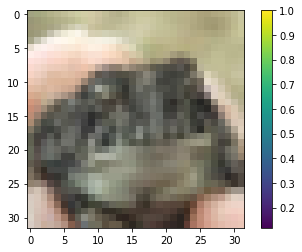

In [ ]:
plt.imshow(train_x[25] / 2 + 0.5)
plt.colorbar()
plt.show()

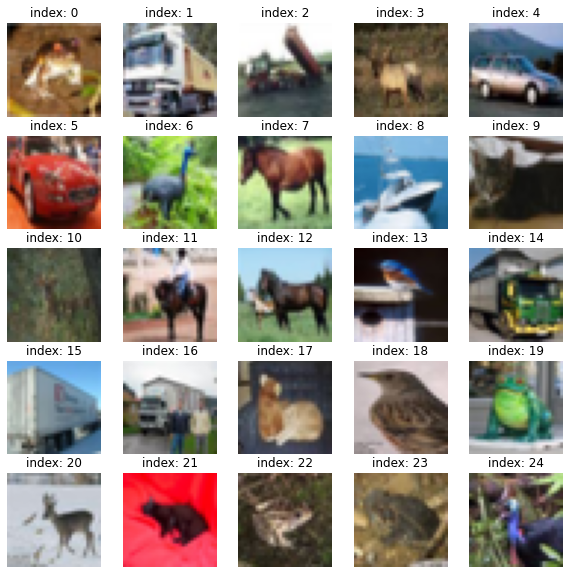

In [ ]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5, 5, i+1) # plt.subplot(row, col, index)
    plt.imshow(train_x[i] / 2 + 0.5)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

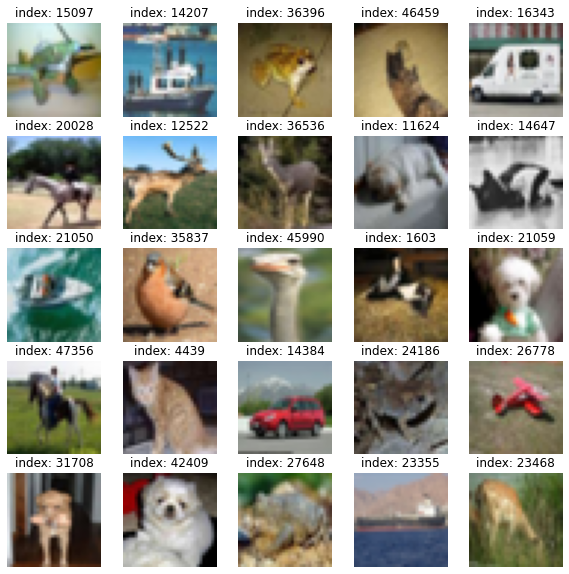

In [ ]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5, 5, i+1) # plt.subplot(row, col, index)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index] / 2 + 0.5)
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 250

In [ ]:
#tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋 구성
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 생성자 모델 구현
* DCGAN(Deep Convolutional GAN)모델 구현

In [ ]:
def make_generator_model_one():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, activation = 'relu', input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum =0.9))
    model.add(layers.LeakyReLU(alpha=0.3))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum =0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum =0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
generator_one = make_generator_model_one()
generator_one.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524288    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [ ]:
#랜덤 노이즈를 입력하여 방금 구현한 생성자로 랜덤 이미지를 생성
noise = tf.random.normal([1, 100])
generated_image = generator_one(noise, training=False)  #가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 생성
generated_image.shape

TensorShape([1, 32, 32, 3])

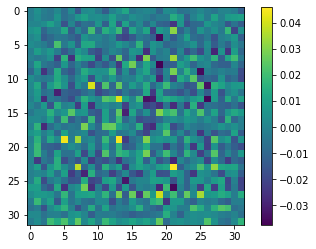

In [ ]:
#시각화
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## 판별자 모델 구현

In [ ]:
def make_discriminator_model_one():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',activation ='relu', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(0.3))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), activation ='relu',padding='same'))
    model.add(layers.LeakyReLU(0.1))
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.BatchNormalization(momentum =0.9))
    model.add(layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum =0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1,activation ='softmax'))

    return model

In [ ]:
discriminator_one = make_discriminator_model_one()

discriminator_one.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 128)       

In [ ]:
decision = discriminator_one(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

## 손실함수와 최적화 함수 구현

### * 손실함수

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### * 최적화 함수

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정 상세 기능 구현

In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator_one(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator_one(images, training=True)
        fake_output = discriminator_one(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_one.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_one.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_one.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_one.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i]*127.5+127.5).astype('uint8'))
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/CIFAR-10/generated_samples/ex1_sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/CIFAR-10/training_history/ex1_train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/CIFAR-10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_one,
                                 discriminator=discriminator_one)


## 학습 과정 진행

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_one, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator_one, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)
        

In [ ]:
save_every = 5
EPOCHS = 300

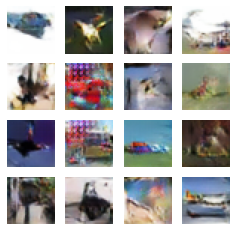

Time for training : 3332 sec


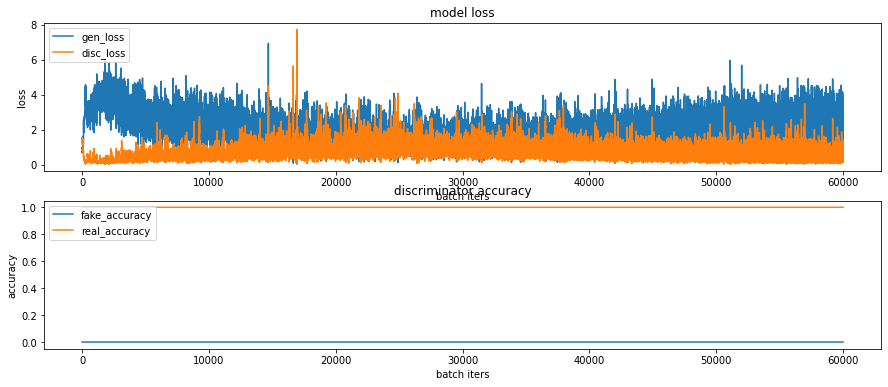

CPU times: user 50min 45s, sys: 43 s, total: 51min 28s
Wall time: 55min 35s


In [ ]:
%%time
with tf.device('/GPU:0'):
  train(train_dataset,EPOCHS,save_every)

In [ ]:
anim_file = '/content/drive/MyDrive/CIFAR-10/cifar10_dcgan1_img.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/CIFAR-10/generated_samples/ex1_sample_epoch*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/CIFAR-10/cifar10_dcgan1_img.gif


-rw------- 1 root root 3004188 Aug 26 12:39 /content/drive/MyDrive/CIFAR-10/cifar10_dcgan1_img.gif


In [ ]:
anim_file = '/content/drive/MyDrive/CIFAR-10/cifar10_dcgan1_G.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/CIFAR-10/training_history/ex1_train_history*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/CIFAR-10/cifar10_dcgan1_G.gif


-rw------- 1 root root 2562012 Aug 26 12:39 /content/drive/MyDrive/CIFAR-10/cifar10_dcgan1_G.gif


## **Model 2**


In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 250

### 생성자 모델

In [ ]:
def make_generator_model_two():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, activation = 'relu', input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum =0.9))
    model.add(layers.LeakyReLU(alpha=0.3))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum =0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum =0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
generator_two = make_generator_model_two()
generator_two.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1654784   
                                                                 
 batch_normalization_5 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 128)        524288    
 ranspose)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 128)       

In [ ]:
#랜덤 노이즈를 입력하여 방금 구현한 생성자로 랜덤 이미지를 생성
noise = tf.random.normal([1, 100])
generated_image = generator_two(noise, training=False)  #가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 생성
generated_image.shape

TensorShape([1, 32, 32, 3])

### 판별자 모델

In [ ]:
def make_discriminator_model_two():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(32, (3,3), strides=(2, 2), padding='same',activation = 'relu', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(0.3))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum =0.99))
    model.add(layers.LeakyReLU(0.1))
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2),activation = 'relu',padding='same'))
    model.add(layers.BatchNormalization(momentum =0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Fourth: Dense Layer
    model.add(layers.Conv2D(256, (3, 3), strides=1 ,padding='same'))
    model.add(layers.BatchNormalization(momentum =0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))


    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator_two = make_discriminator_model_two()

discriminator_two.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_8 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 64)          0         
                                                      

In [ ]:
decision = discriminator_two(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4993641]], dtype=float32)>

In [ ]:
@tf.function
def train_step2(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator_two(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator_two(images, training=True)
        fake_output = discriminator_two(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_two.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_two.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_two.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_two.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i]*127.5+127.5).astype('uint8'))
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/CIFAR-10/generated_samples2/ex2_sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/CIFAR-10/training_history2/ex2_train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/CIFAR-10/training_checkpoints2'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_two,
                                 discriminator=discriminator_two)


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [ ]:
def train2(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step2(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_two, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator_two, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)
        

In [ ]:
save_every = 5
EPOCHS = 300

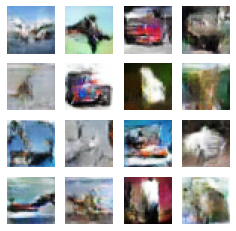

Time for training : 3515 sec


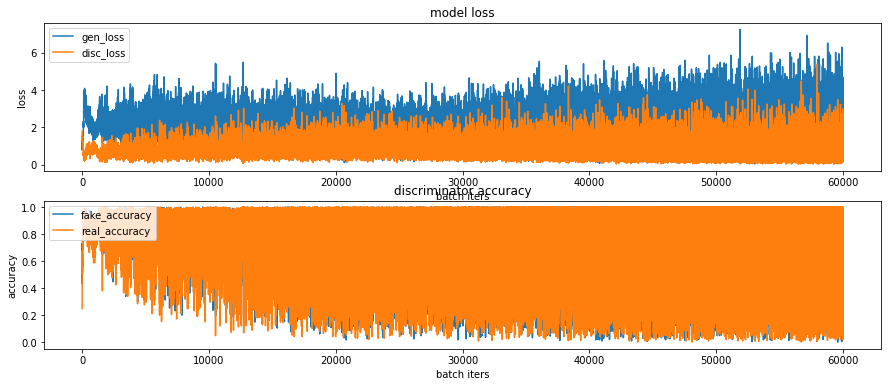

CPU times: user 52min 54s, sys: 36.9 s, total: 53min 31s
Wall time: 58min 39s


In [ ]:
%%time
with tf.device('/GPU:0'):
  train2(train_dataset,EPOCHS,save_every)

In [ ]:
anim_file = '/content/drive/MyDrive/CIFAR-10/cifar10_dcgan2_img.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/CIFAR-10/generated_samples/ex2_sample_epoch*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/CIFAR-10/cifar10_dcgan2_img.gif


In [ ]:
anim_file = '/content/drive/MyDrive/CIFAR-10/cifar10_dcgan2_G.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/CIFAR-10/training_history2/ex2_train_history*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/CIFAR-10/cifar10_dcgan2_G.gif


## **Model 3**

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 125

### 생성자 모델

In [ ]:
def make_generator_model_three():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, activation = 'relu', input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum =0.9))
    model.add(layers.LeakyReLU(alpha=0.3))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum =0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum =0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
generator_three = make_generator_model_three()
generator_three.summary()

In [ ]:
#랜덤 노이즈를 입력하여 방금 구현한 생성자로 랜덤 이미지를 생성
noise = tf.random.normal([1, 100])
generated_image = generator_two(noise, training=False)  #가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 생성
generated_image.shape

### 판별자 모델

In [ ]:
def make_discriminator_model_three():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (2,2), strides=(2, 2), padding='same',activation = 'relu', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(0.1))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(32, (2, 2), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(momentum =0.99))
    model.add(layers.LeakyReLU(0.1))
    model.add(layers.Dropout(0.2))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2),activation = 'relu',padding='same'))
    model.add(layers.BatchNormalization(momentum =0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum =0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fourth: Dense Layer
    model.add(layers.Conv2D(256, (4, 4), strides=1 ,padding='same'))
    model.add(layers.BatchNormalization(momentum =0.99))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(0.3))

    # Flatten Layer()
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator_three = make_discriminator_model_three()

discriminator_three.summary()

In [ ]:
decision = discriminator_three(generated_image, training=False)
decision

In [ ]:
@tf.function
def train_step3(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator_three(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator_three(images, training=True)
        fake_output = discriminator_three(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_three.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_three.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_three.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_three.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i]*127.5+127.5).astype('uint8'))
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/CIFAR-10/generated_samples3/ex3_sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/CIFAR-10/training_history3/ex3_train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/CIFAR-10/training_checkpoints3'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_three,
                                 discriminator=discriminator_three)


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

In [ ]:
def train3(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step3(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_three, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator_three, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)
        

In [ ]:
save_every = 5
EPOCHS = 500

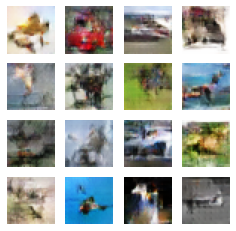

Time for training : 5939 sec


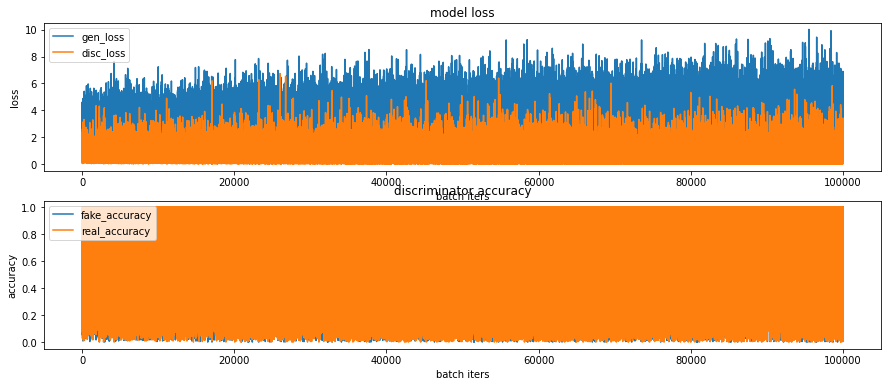

CPU times: user 1h 39min 3s, sys: 1min 38s, total: 1h 40min 42s
Wall time: 1h 39min 5s


In [ ]:
%%time
with tf.device('/GPU:0'):
  train2(train_dataset,EPOCHS,save_every)

In [ ]:
anim_file = '/content/drive/MyDrive/CIFAR-10/cifar10_dcgan3_img.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/CIFAR-10/generated_samples3/ex3_sample_epoch*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/CIFAR-10/cifar10_dcgan3_img.gif


-rw------- 1 root root 3709424 Aug 26 15:17 /content/drive/MyDrive/CIFAR-10/cifar10_dcgan3_img.gif


In [ ]:
anim_file = '/content/drive/MyDrive/CIFAR-10/cifar10_dcgan3_G.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/CIFAR-10/training_history3/ex3_train_history*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/CIFAR-10/cifar10_dcgan3_G.gif


-rw------- 1 root root 5149539 Aug 26 15:17 /content/drive/MyDrive/CIFAR-10/cifar10_dcgan3_G.gif


# 회고

[GAN Model이 진동하는 이유]

https://dl-ai.blogspot.com/2017/08/gan-problems.html

## 결과 정리 

● Model One

> generator
>>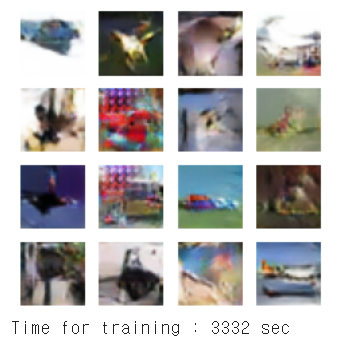

> training history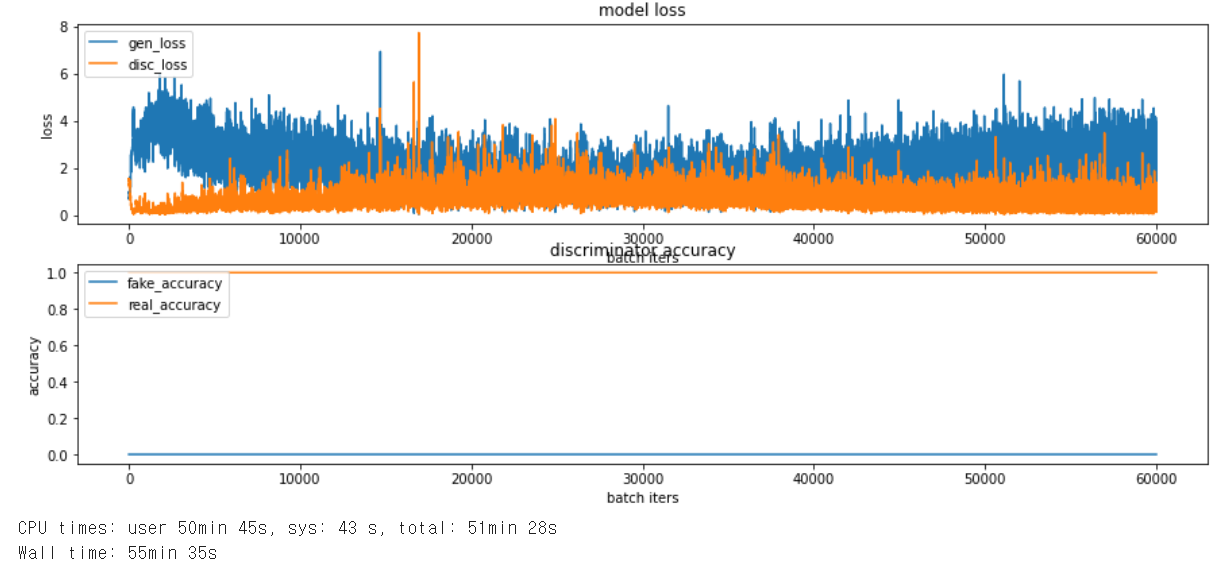
>>

● Model Two

> generator
>> 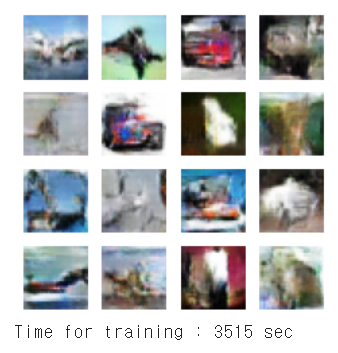

> training history
>>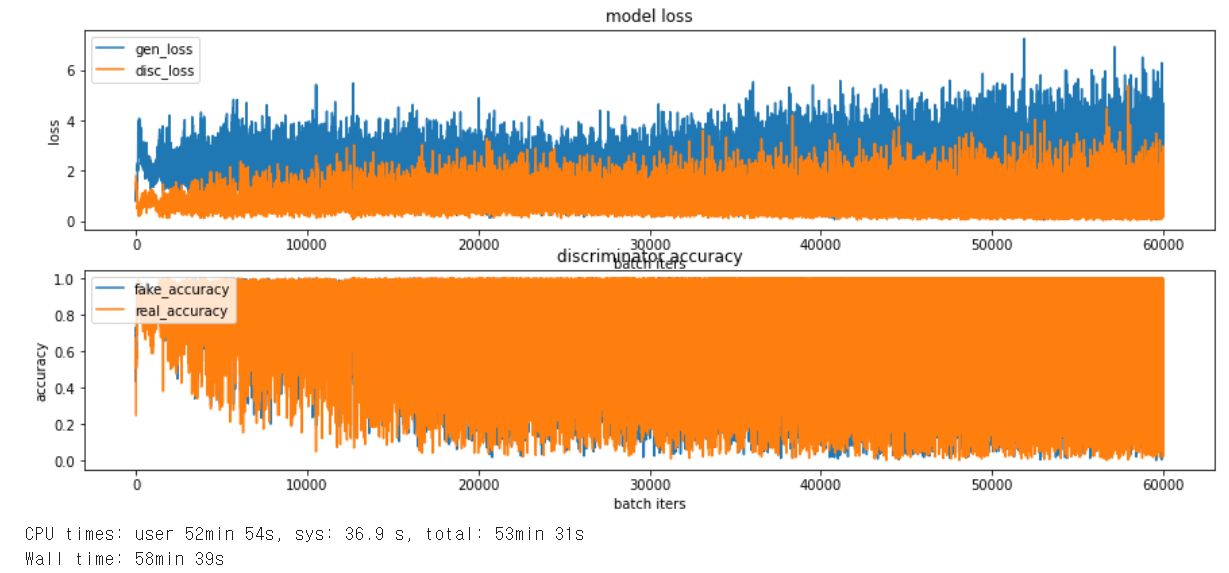

● Model Three

> generator
>> 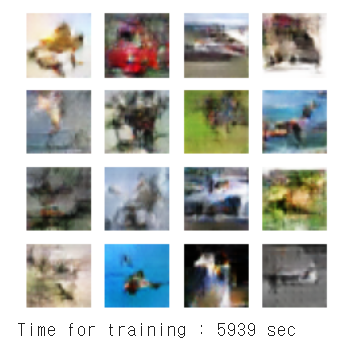

> training history
>>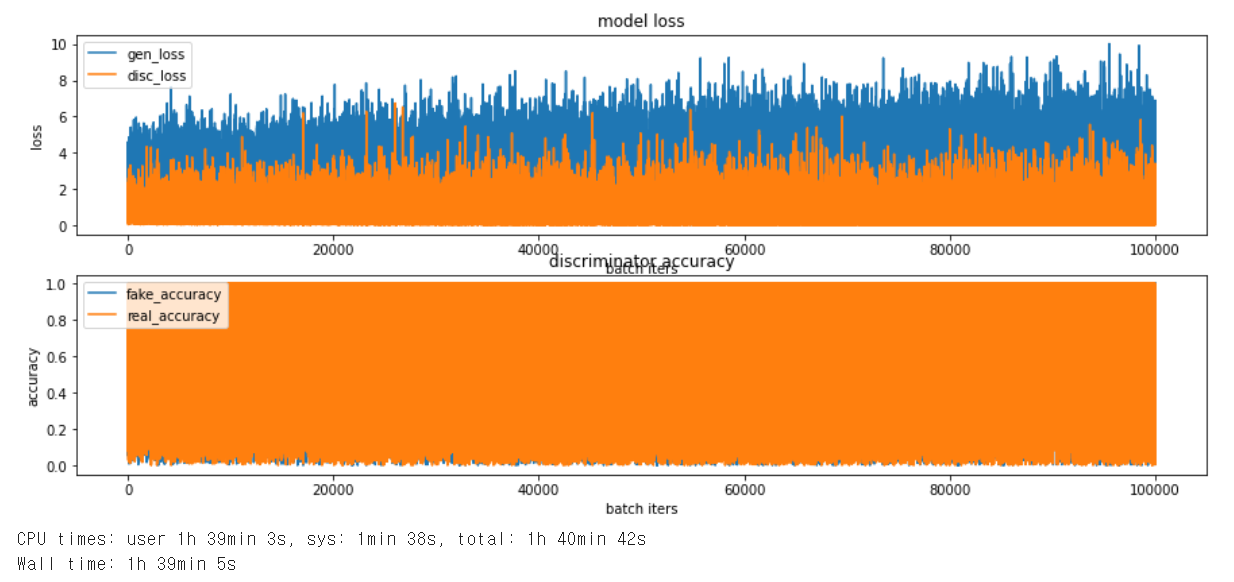

* 결과적으로 생성자는 눈에 띄게 좋은 결과로 보여지나  각 모델의 판별자의 결과를 보면 진동이 너무 심하다는 점을 볼 수 있다. 

* Model One의 경우 
> - 마지막 판별하는 활성함수를 softmax(다중 분류)를 사용해서 뜻밖의 결과를 얻었다 즉, 이중 분류 문제를 다중 분류기를 사용하는 경우 정답과 정반대의 결과를 초래할 수 있다는 것을 그래프를 보면 알 수 있고 이는 즉, 판별자는 올바르게 판별할 수 없는 성능이 매우 안좋다 라는 결론을 내릴 수 있다. 

* Model Two의 경우 
> - 전반적으로 fake accuracy가 추세적으로 0.5를 향해 하향하고 있는 것을 확인할 수 있다
> - 하지만, 그래프를 보면 매우 크게 진동하는 모습을 볼 수 있는데 이는 위의 GAN모델이 해결해야하는 과제 중 하나이다. 

* Model Three의 경우 
> - 이 모델은 Two 모델의 계층과 약간의 파라미터를 수정한 부분이다. 계층이 하나 추가 되어 새로운 특징을 찾아내어 성능이 좋아졌을 가능성이 있다. 
> - 하지만, 그래프를 보면 fack accuracy를 보면 처음부터 0~1 사이로 크게 진동하는것을 볼 수 있다. 즉 판별자가 생성자의 생성 이미지에 대하여 확신하여 진실인지 거짓인지 판단할 수 없다라는 결론으로 보여진다 
> - 이는 계층 추가로 판별자의 판별을 좋아졌다, 나빠졌다라고 정확히 결론을 내리긴 어렵지만 진동의 두께를 보면 계층이 깊어지면서 누적 그래프 (면적 그래프) 형태가 되는데 이는 누적으로 인해 판별자의 판별 기준을 흐리게 하여 성능을 저하시키는 것이 아닌가하는 생각이 들게 하는 형태임

✍ 회고
* 생성자와 판별자의 모델을 설계하면서 도출되는 결과를 보면서 신기하다 이것이 딥러닝의 매력인가?라는 느낌을 받음 

* 첫번째 모델을 설계 후 그래프를 확인하고나서 난처한 기분이였고, 어디서 잘못 설계한건지 논리적으로 찾기까지는 오래걸렸던거 같다. 즉 시그모이드 활성화함수(이진분류) 사용해야 했으나, 설계 당시 생성자의 이미지를 분류하는것이라고 착각하여 softmax 함수를 사용한 것이 화근이 되었고, 논리 실수로 인한 재밌는 결과를 얻었던거 같음

* 생성자 모델은 너무 잘 만들어져서 판별자의 성능을 올리고 싶었으나, 그래프의 결과를 보면 진동과 누적으로 인한 오류들로 성능이 계속적으로 나오지 않는 결과가 반복되었고, 이에 대한 좋은 아이디어가 떠오르지 않았으며, 주어진 시간에 대해 생각하는 모델을 만들기에는 짧았던 프로젝트였음.



[참고한 블로그 - https://zzcojoa.tistory.com/89?category=1035878]

